In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DATA_INPUT_PATH = '/kaggle/input/fer2013/fer2013.csv'
DATA_OUTPUT_PATH = '/kaggle/working/dataset/'

In [3]:
def load_csv():
    try:
        if os.path.exists(DATA_INPUT_PATH):
            df = pd.read_csv(DATA_INPUT_PATH)
            return df
    except Exception as e:
        raise FileNotFoundError(
            f"Error occurred during data download: {str(e)}")
df = load_csv()

In [4]:
def organize_dataset():
    train_dir = os.path.join(DATA_OUTPUT_PATH, 'train/')
    validation_dir = os.path.join(DATA_OUTPUT_PATH, 'val/')
    test_dir = os.path.join(DATA_OUTPUT_PATH, 'test/')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    train_df = df[df['Usage'] == 'Training']
    val_df = df[df['Usage'] == 'PublicTest']
    test_df = df[df['Usage'] == 'PrivateTest']

    train_df.to_csv(os.path.join(train_dir, 'train.csv'), index=False)
    val_df.to_csv(os.path.join(validation_dir, 'val.csv'), index=False)
    test_df.to_csv(os.path.join(test_dir, 'test.csv'), index=False)

organize_dataset()

In [12]:
IMAGE_WIDTH = 48
IMAGE_HEIGHT = 48
IMAGE_DEPTH = 1
CLASS_LABELS = [0, 1, 2, 3, 4, 5, 6]
CLASS_NAMES = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def preprocess_pixels(pixel_string):
    pixels = np.array(pixel_string.split(), dtype=int)
    # Assuming images are grayscal
    return pixels.reshape((IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH))

train_dataFrame = pd.read_csv(os.path.join(DATA_OUTPUT_PATH, 'train/train.csv'))
val_dataFrame = pd.read_csv(os.path.join(DATA_OUTPUT_PATH, 'val/val.csv'))
test_dataFrame = pd.read_csv(os.path.join(DATA_OUTPUT_PATH, 'test/test.csv'))

train_dataFrame = train_dataFrame[train_dataFrame.emotion.isin(CLASS_LABELS)]
val_dataFrame = val_dataFrame[val_dataFrame.emotion.isin(CLASS_LABELS)]
test_dataFrame = test_dataFrame[test_dataFrame.emotion.isin(CLASS_LABELS)]

# Convert categorical labels to one-hot encoded format
train_labels = tf.keras.utils.to_categorical(
    train_dataFrame['emotion'].apply(lambda x: x))
val_labels = tf.keras.utils.to_categorical(
    val_dataFrame['emotion'].apply(lambda x: x))
test_labels = tf.keras.utils.to_categorical(
    test_dataFrame['emotion'].apply(lambda x: x))

train_dataFrame['pixels'] = train_dataFrame['pixels'].apply(preprocess_pixels)
val_dataFrame['pixels'] = val_dataFrame['pixels'].apply(preprocess_pixels)
test_dataFrame['pixels'] = test_dataFrame['pixels'].apply(preprocess_pixels)

In [13]:
BATCH_SIZE = 32
        
def make_generators():

    # Create data generators for train, validation, and test sets
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        zca_whitening=False,
        #     fill_mode='nearest',
        #     brightness_range=[0.5, 1.5],  # Experiment with brightness adjustments
        #     channel_shift_range=50.0
    )
    validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)

    # Define generators
    train_generator = train_datagen.flow(
        x=np.array(train_dataFrame['pixels'].tolist()),  # input data
        y=train_labels,
        batch_size=BATCH_SIZE
    )

    validation_generator = validation_datagen.flow(
        x=np.array(val_dataFrame['pixels'].tolist()),  # input data
        y=val_labels,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_generator = test_datagen.flow(
        x=np.array(test_dataFrame['pixels'].tolist()),  # input data
        y=test_labels,
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = make_generators()

In [14]:
def build_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(48, 48, 1)),
        tf.keras.layers.Conv2D(64, (5, 5), activation='elu',
                               padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (5, 5), activation='elu',
                               padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='elu',
                               padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (5, 5), activation='elu',
                               padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv2D(256, (3, 3), activation='elu',
                               padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='elu',
                               padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), activation='elu',
                               padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), activation='elu',
                               padding='same', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='elu',
                              kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='elu',
                              kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(CLASS_LABELS), activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

In [15]:
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [18]:
EPOCHS = 100

def train_model():

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.00008,
        patience=11,
        verbose=1,
        restore_best_weights=True,
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        min_delta=0.0001,
        factor=0.25,
        patience=4,
        min_lr=1e-7,
        verbose=1,
    )
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[
            early_stopping,
            lr_scheduler
        ]
    )
    return history

history = train_model()

Epoch 1/100
898/898 [==============================] - 30s 33ms/step - loss: 0.7813 - accuracy: 0.7191 - val_loss: 0.9217 - val_accuracy: 0.6726 - lr: 3.9063e-06
Epoch 2/100
898/898 [==============================] - 30s 33ms/step - loss: 0.7818 - accuracy: 0.7166 - val_loss: 0.9230 - val_accuracy: 0.6715 - lr: 3.9063e-06
Epoch 3/100
898/898 [==============================] - 29s 33ms/step - loss: 0.7744 - accuracy: 0.7185 - val_loss: 0.9231 - val_accuracy: 0.6709 - lr: 3.9063e-06
Epoch 4/100
898/898 [==============================] - 29s 33ms/step - loss: 0.7729 - accuracy: 0.7196 - val_loss: 0.9234 - val_accuracy: 0.6709 - lr: 3.9063e-06
Epoch 5/100
898/898 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.7181
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
898/898 [==============================] - 30s 33ms/step - loss: 0.7778 - accuracy: 0.7181 - val_loss: 0.9226 - val_accuracy: 0.6707 - lr: 3.9063e-06
Epoch 6/100
898/898 [========

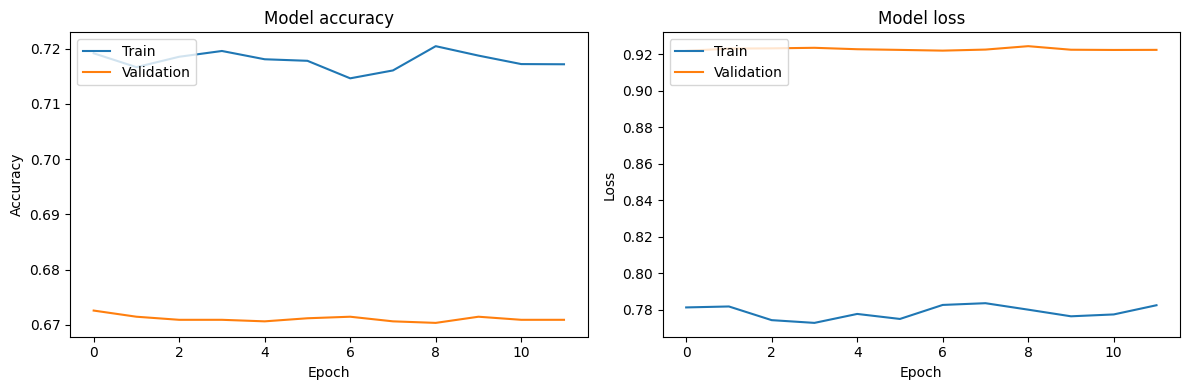

In [19]:
def visualize_train_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

visualize_train_history(history)

In [20]:
def evaluate_model():
    accuracy = model.evaluate(test_generator)
    print("Test Accuracy:", accuracy[1])

evaluate_model()

113/113 [==============================] - 1s 10ms/step - loss: 0.8569 - accuracy: 0.6899
Test Accuracy: 0.6898857355117798


113/113 [==============================] - 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

       Anger       0.60      0.63      0.62       491
     Disgust       0.80      0.64      0.71        55
        Fear       0.57      0.45      0.50       528
       Happy       0.89      0.89      0.89       879
         Sad       0.55      0.55      0.55       594
    Surprise       0.79      0.76      0.78       416
     Neutral       0.64      0.74      0.68       626

    accuracy                           0.69      3589
   macro avg       0.69      0.67      0.68      3589
weighted avg       0.69      0.69      0.69      3589



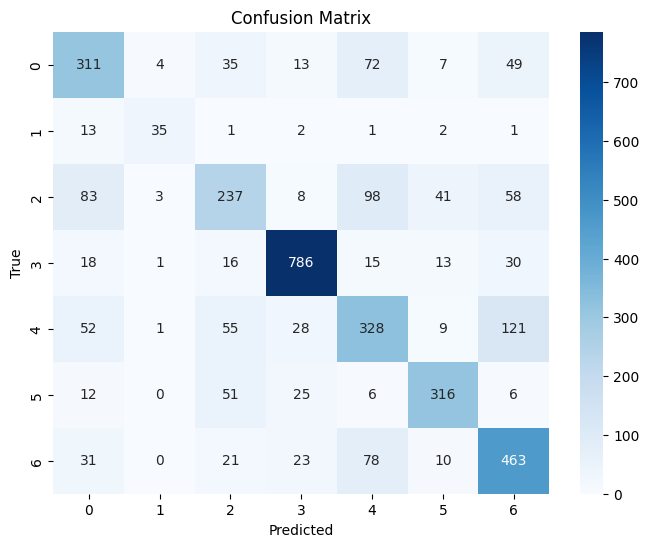

In [21]:
def report():

    # Make predictions
    predictions = model.predict(test_generator)

    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Print the classification report

    report = classification_report(
        true_labels, predicted_labels, target_names=CLASS_NAMES, zero_division=1)
    print("Classification Report:")
    print(report)

    # Visualize confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(len(CLASS_LABELS)), yticklabels=range(len(CLASS_LABELS)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
report()

In [23]:
MODEL_NAME = 'fer_2013_69_acc'
MODEL_OUTPUT_PATH = '/kaggle/working/'
        
def save_model():
    """
    Save the trained emotion recognition model.
    """
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
    model.save(os.path.join(
        MODEL_OUTPUT_PATH, f'{MODEL_NAME}.h5'))
    
save_model()

## Inference

In [24]:
def predict_and_visualize():
    # Make predictions
    predictions = model.predict(test_generator)

    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Select a few images for visualization
    sample_indices = np.random.choice(len(test_dataFrame), size=5, replace=False)

    for idx in sample_indices:
        # Get the original image
        original_image = np.array(test_dataFrame['pixels'].iloc[idx])

        # Reshape the image to (48, 48) assuming it was flattened
        original_image = original_image.reshape((48, 48))

        # Make a prediction for the current image
        current_prediction = predictions[idx]
        predicted_class = np.argmax(current_prediction)
        true_class = np.argmax(test_labels[idx])

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Display the image
        ax.imshow(original_image, cmap='gray')

        # Add a bounding box around the detected face
        rect = plt.Rectangle((0, 0), 48, 48, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add the predicted and true labels as text
        plt.text(0, 50, f'Predicted: {CLASS_NAMES[predicted_class]}', color='r')
        plt.text(0, 45, f'True: {CLASS_NAMES[true_class]}', color='g')

        # Save or display the image
#             plt.savefig(f'result_image_{idx}.png')
        plt.show()

113/113 [==============================] - 1s 9ms/step


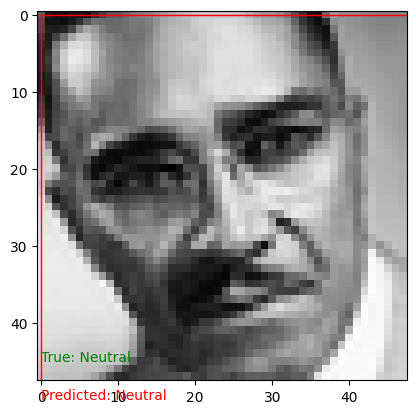

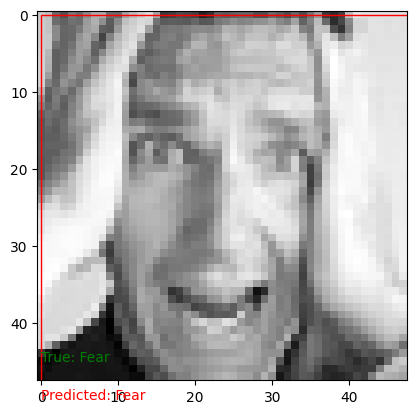

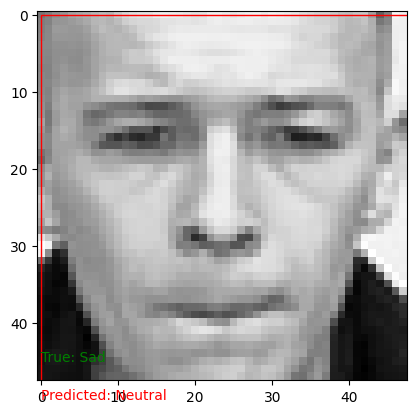

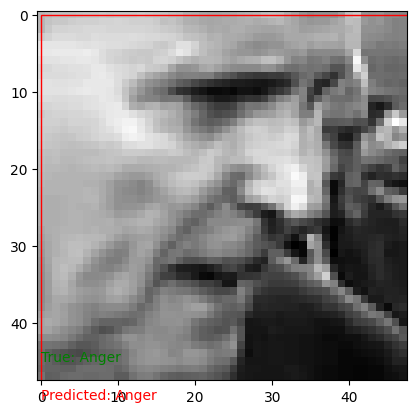

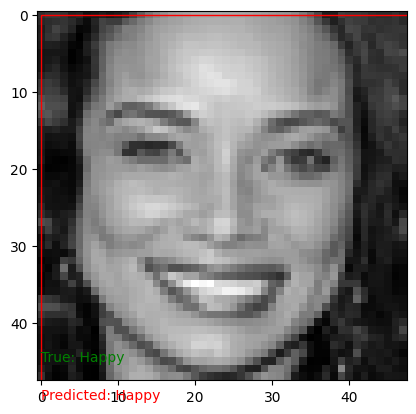

In [25]:
predict_and_visualize()